<a href="https://colab.research.google.com/github/Mennah54/Fine_tuning/blob/main/ResNet50_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader

def get_dataloader(batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader

def get_model(num_classes=10):
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = True

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    return model

def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    loss_total = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = loss_total / len(test_loader)
    print(f"Test Accuracy: {accuracy:.2f}%, Test Loss: {avg_loss:.4f}")
    return accuracy, avg_loss

def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.0001):  # زيادة عدد التكرارات وتقليل معدل التعلم
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # إضافة weight decay

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    return model

train_loader, test_loader = get_dataloader()
model = get_model()
trained_model = train_model(model, train_loader, test_loader)
evaluate_model(trained_model, test_loader)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10, Loss: 0.3607, Accuracy: 88.45%
Epoch 2/10, Loss: 0.1810, Accuracy: 94.01%
Epoch 3/10, Loss: 0.1410, Accuracy: 95.44%
Epoch 4/10, Loss: 0.1163, Accuracy: 96.17%
Epoch 5/10, Loss: 0.1024, Accuracy: 96.53%
Epoch 6/10, Loss: 0.0868, Accuracy: 97.15%
Epoch 7/10, Loss: 0.0800, Accuracy: 97.35%
Epoch 8/10, Loss: 0.0765, Accuracy: 97.49%
Epoch 9/10, Loss: 0.0694, Accuracy: 97.71%
Epoch 10/10, Loss: 0.0639, Accuracy: 97.89%
Test Accuracy: 94.13%, Test Loss: 0.1850


(94.13, 0.18504502144968435)

In [ ]:
torch.save(model.state_dict(), "resnet50_finetuned.pth")


Files already downloaded and verified


<ipython-input-88-8ba4b3a1b728>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet50_finetuned.pth", map_location=device))


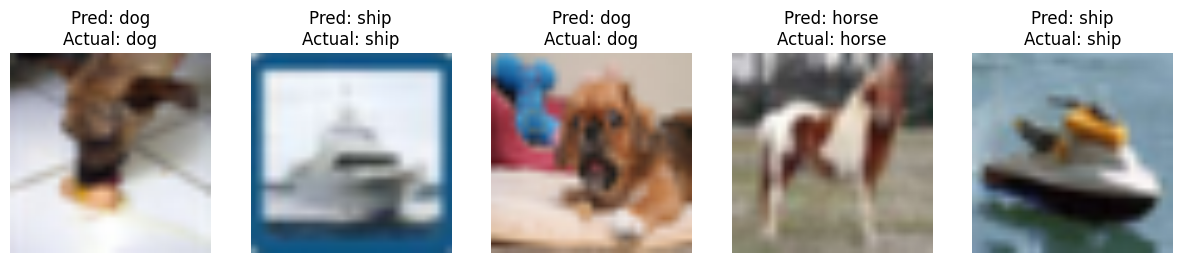

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

model.load_state_dict(torch.load("resnet50_finetuned.pth", map_location=device))
model.to(device)
model.eval()

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

images = images.cpu().numpy()
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
for i in range(5):
    img = np.transpose(images[i], (1, 2, 0))
    img = img * 0.5 + 0.5
    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {classes[predicted[i]]}\nActual: {classes[labels[i]]}")
    axes[i].axis("off")

plt.show()
